# Dataset(s) to be used:
**Unit of analysis: Census tracts**
**1. CalEnviroScreen (Version 2.0, 3.0, 4.0)**: https://oehha.ca.gov/calenviroscreen/sb535 
- Source: Office of Environmental Health Hazard Assessment (OEHHA), part of California Environmental Protection Agency (CalEPA).
- Frequency: Published at three intervals:
Version 2.0 (2009-2011): https://data.ca.gov/dataset/calenviroscreen-2-0
Version 3.0 (2012-2014): https://data.ca.gov/dataset/calenviroscreen-3-0-results
Version 4.0 (2017-2019): https://data.ca.gov/dataset/calenviroscreen-4-0
- Variables Used:
**Pollution Burden Score (Y):**
  https://la.myneighborhooddata.org/2021/06/pollution-burden/
  Ranges from 1 to 10, calculated from factors like particulate matter, drinking water, and hazardous waste.
**Disadvantaged Community (DAC) Designation (X2):**
  https://www.caclimateinvestments.ca.gov/annual-report-2018
  Binary indicator (1 = DAC, 0 = Non-DAC) based on CalEnviroScreen criteria.

**2. California Climate Investments (2015-2019)**
- Source: California Climate Investments (CCI) project, linked to the Cap-and-Trade program.
- Frequency: Data on investments from 2015 to 2019, at the census tract level.
- Variables Used:
**Investment Amount (X1):**
  https://gis.data.cnra.ca.gov/datasets/6e3e600538a24df88a7499a3bdf6e1d1_0/explore
  Total dollar amount of climate investment per census tract.
**Funding Trends:** Year-wise breakdown of funds allocated to DACs and Non-DACs.

# Analysis Question
**Do DACs receive significantly higher investment per capita compared to Non-DACs?**

# Background
- **Cap and trade program:** Market based policy that aims to reduce GHG emissions. Allows entities to purchase and sell allowances in the open market. Entities can either buy allowances for emissions, reduce emissions or buy offsets to reduce emissions elsewhere.

- When entities purchase allowances it creates revenues for the states that can then be reinvested.

- In California these investments are being made in several projects that target pollution such as in low carbon transit systems, reducing agricultural emissions and community solar projects.

- **Cap-and-trade program** implemented in 2012 with the law, Senate Bill 535, which dictates that at least 25% of the revenue from the program should be invested in **disadvantaged communities (DACs)** to reduce greenhouse gas emissions.

- California designated certain census tracts as disadvantaged based on factors like poverty, unemployment, education as well as pollution and published this data thrice in what it calls **"CalEnviroScreen"**.

- Investments for climate action starting flowing in 2014

- However, it remained unclear whether these investments were benefiting the DACs more than **non-disadvantaged communities (non-DACs)**.

- It also remained to be investigated whether these investments have the same return per dollar in DACs as compared to non-DACs.

# Data Cleaning & Preparation
**Merging:** The CalEnviroScreen data, investment data, and census tract identifiers were combined using the Census Tract ID (GEOID) as a key.

**Variable Creation:**
- Investment per Capita: Calculated as total investment divided by the population of the census tract.
- Funding Category: Classified census tracts into "Low," "Medium," and "High" investment categories.

# Columns that will (likely) be used:
1. **id:** Unique identifier for each region or observation.
2. **year:** The year corresponding to the observation.
3. **score:** A measure that might be useful for descriptive analysis or subgroup analysis.
4. **DAC:** Binary indicator (1 = DAC, 0 = Non-DAC) used to classify regions as DACs or Non-DACs.
5. **funds:** The amount of investment per capita, which is the key variable of interest for hypothesis testing.

# Columns to be used to merge/join them:
- Dataset 1: Pollution — id
- Dataset 2: Disadvantaged — id
- Dataset 3: Investment — id and year
These columns are used as the keys to merge the datasets, ensuring that observations align correctly across the three datasets.

# Hypothesis Testing
- **Research Question:** Do DACs receive significantly higher investment per capita compared to Non-DACs?
- **Null Hypothesis (H₀):** There is no significant difference in investment per capita between DACs and Non-DACs.
- **Alternative Hypothesis (Hₐ):** DACs receive significantly higher investment per capita than Non-DACs.

# Methodology
To test this hypothesis, we performed an independent t-test using Welch's t-test (which does not assume equal variances) to compare the mean investment per capita between DACs and Non-DACs.

1. Grouping:
- DACs: Observations where the DAC column equals 1.
- Non-DACs: Observations where the DAC column equals 0.

2. Test Statistic:
- T-statistic: Measures the magnitude of difference between the two sample means relative to the spread or variability of their sample distributions.

3. P-value:
This value determines the strength of the evidence against the null hypothesis.

4. Significance Level (α):

A significance level of 0.05 (5%) was used to make the decision.

In [27]:
# Import required libraries
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import scipy.stats as stats

In [28]:
# Pollution Burden (Y)
# Load data
pollution_2011 = pd.read_excel("CalEnviroScreen 2.0 (2009-2011).xlsx")
pollution_2014 = pd.read_excel("CalEnviroScreen 3.0 (2012-2014).xlsx")
pollution_2019 = pd.read_excel("CalEnviroScreen 4.0 (2017-2019).xlsx")

In [38]:
# Clean data
pollution_2011_clean = (
    pollution_2011.rename(columns={"Census Tract": "id", "Pollution Burden Score": "score_2011"})
    .assign(id=lambda x: x['id'].astype(str).str.zfill(11), score_2011=lambda x: x['score_2011'].round(2))
    .loc[:, ['id', 'score_2011']]
)

pollution_2014_clean = (
    pollution_2014.rename(columns={"Census Tract": "id", "Pollution Burden Score": "score_2014"})
    .assign(id=lambda x: x['id'].astype(str).str.zfill(11), score_2014=lambda x: x['score_2014'].round(2))
    .loc[:, ['id', 'score_2014']]
)

pollution_2019_clean = (
    pollution_2019.rename(columns={"Census Tract": "id", "Pollution Burden Score": "score_2019"})
    .assign(id=lambda x: x['id'].astype(str).str.zfill(11), score_2019=lambda x: x['score_2019'].round(2))
    .loc[:, ['id', 'score_2019']]
)

# Join datasets
pollution_wide = (
    pollution_2011_clean
    .merge(pollution_2014_clean, on='id', how='inner')
    .merge(pollution_2019_clean, on='id', how='inner')
)

# Reshape to long format
pollution = pollution_wide.melt(id_vars='id', var_name='year', value_name='score')
pollution['year'] = pollution['year'].str.extract(r'(\d{4})').astype(int)
pollution.dropna(inplace=True)

# Save pollution data
pollution.to_csv("pollution.csv", index=False)

In [39]:
# California Climate Investments (X)
investment_2019 = pd.read_excel("California Climate Investments (2015-2019).xlsx")

# Clean data
investment_clean = (
    investment_2019.rename(columns={"Census Tract": "id", "Reporting Year": "year", "Total GGRF Funds Implemented": "funds"})
    .assign(id=lambda x: x['id'].astype(str).str.zfill(11), year=lambda x: x['year'].astype(str).str[:4])
    .loc[:, ['id', 'year', 'funds']]
    .dropna()
    .groupby(['id', 'year'], as_index=False)
    .agg({'funds': 'sum'})
)

# Sum funds from 2015 to 2019
investment_sum = investment_clean.groupby('id', as_index=False).agg({'funds': 'sum'})
investment_sum['year'] = 2019  # Explicitly add the year for clarity

# Save investment data
investment_clean.to_csv("investment.csv", index=False)
investment_sum.to_csv("investment_sum.csv", index=False)

In [40]:
# Disadvantaged Communities (Treatment)
disadvantaged_2016 = pd.read_csv("DisadvantagedCommunities (2016).csv")

# Clean data
disadvantaged = (
    disadvantaged_2016.rename(columns={"GEOID10_1": "id", "DAC16": "DAC"})
    .assign(id=lambda x: x['id'].astype(str).str.zfill(11))
    .replace({"DAC": {"Y": "disadvantaged", "N": "non-disadvantaged", "Data Not Available": None}})
    .dropna()
    .loc[:, ['id', 'DAC']]
)

In [41]:
# === Merge All Datasets ===
# Ensure 'id' column has consistent data type
pollution['id'] = pollution['id'].astype(str).str.zfill(11)
disadvantaged['id'] = disadvantaged['id'].astype(str).str.zfill(11)
investment_sum['id'] = investment_sum['id'].astype(str).str.zfill(11)  # Ensure 'id' in investment_sum also matches

# Merge pollution, disadvantaged, and investment data
df = (
    pollution
    .merge(disadvantaged, on='id', how='inner')
    .merge(investment_sum, on='id', how='left')  # Merge only on 'id' since 'year' is not common
    .fillna({'funds': 0})  # Replace missing funds with 0
    .dropna()
)

# Save the final dataframe
df.to_csv("df.csv", index=False)

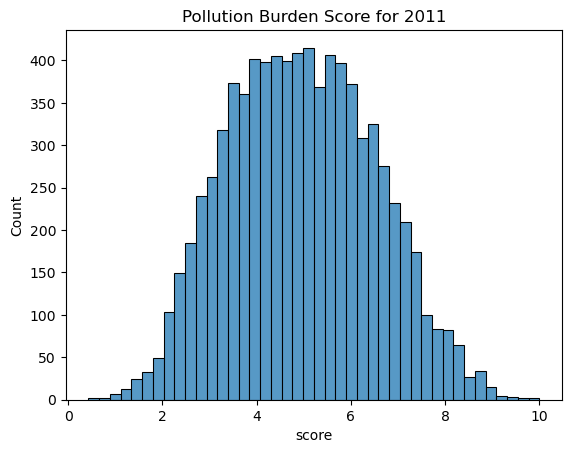

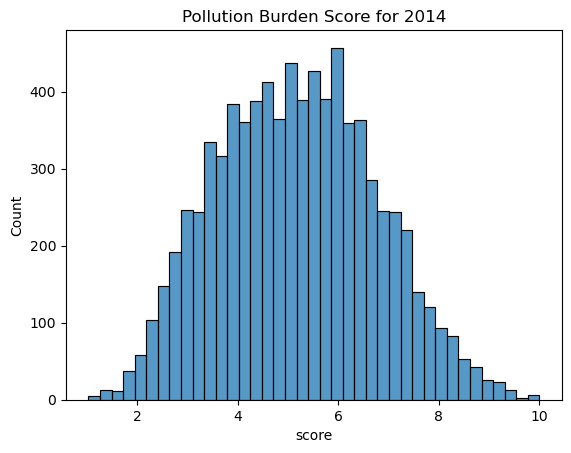

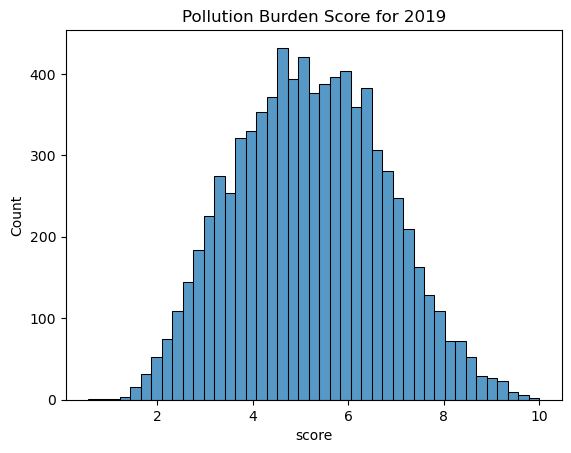

In [42]:
# Histogram of pollution
for year in [2011, 2014, 2019]:
    sns.histplot(data=pollution[pollution['year'] == year], x='score')
    plt.title(f"Pollution Burden Score for {year}")
    plt.show()

In [53]:
df = pd.read_csv('df.csv')

In [54]:
# Create two groups: DACs and Non-DACs
dacs = df[df['DAC'] == "disadvantaged"]['funds']
non_dacs = df[df['DAC'] == "non-disadvantaged"]['funds']
dacs

18            0
19            0
20       137663
36            0
37            0
          ...  
23881         0
23882      6057
23886         0
23887         0
23888     99712
Name: funds, Length: 8202, dtype: int64

In [55]:
# Perform an independent t-test to compare the means of the two groups using scipy.stats
t_stat, p_value = stats.ttest_ind(dacs, non_dacs, equal_var=False)  # Welch's t-test (unequal variance assumed)

# Print the results
print("T-statistic:", t_stat)
print("P-value:", p_value)

# Set significance level (alpha)
alpha = 0.05

# Decision based on the p-value
if p_value < alpha:
    print("Reject the null hypothesis: DACs receive significantly higher investment per capita than Non-DACs.")
else:
    print("Fail to reject the null hypothesis: No significant difference in investment per capita between DACs and Non-DACs.")


T-statistic: -13.728863553698448
P-value: 1.1242566899954054e-42
Reject the null hypothesis: DACs receive significantly higher investment per capita than Non-DACs.


# Hypothesis Testing Results

**Research Question:** Do Disadvantaged Communities (DACs) receive significantly higher investment per capita compared to Non-DACs?

**Hypotheses:**

Null Hypothesis (H₀): There is no significant difference in investment per capita between DACs and Non-DACs.
Alternative Hypothesis (Hₐ): DACs receive significantly higher investment per capita than Non-DACs.

**Test Results:**

- T-statistic: -13.73
- P-value: 1.12 × 10⁻⁴²

Given that the p-value is far below the significance level (α = 0.05), we reject the null hypothesis. This result provides strong statistical evidence that DACs receive significantly higher investment per capita compared to Non-DACs. The negative t-statistic indicates that the mean investment per capita for DACs is substantially higher than that of Non-DACs.

These findings highlight the effectiveness of targeted funding strategies, suggesting that resources are being allocated preferentially to DACs. This result may inform future policy decisions related to equitable investment distribution.